#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [3]:
# feature selection function by VIF and removing low variance features

def feature_select(file_name):
    data = pd.read_csv(file_name)

    data['time column']= data['FFLP_in_months']
    data['event column']= data['FFLP']

    data1=data.drop(columns=['filename'])
    lola=data1.iloc[:,0:255]

    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    X = lola
    data2 = calculate_vif_(X, 10)
    data2[['time column']] = lola[['time column']]

    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    # saving a copy to not repeat VIF again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName)

    return data2

In [28]:
# Gridsearch funciton for random survival forest

def gridsearch(data2, file_name):
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]

    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    X=data2[newX]
    E=data2['event column']

    num_tree=(10, 12, 15, 20, 50)
    max_depth=(1, 2, 3, 4, 5, 6, 10, 12, 15)
    min_node=(1, 2, 3, 4, 5, 10, 12, 15, 20)
    k_folds = 5
    
    Xnew = X
    Enew = E
    features2 = features

    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0

    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                cc=[]
                kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
                i=1
                for train_index, test_index in kf.split(Xnew,Enew):
                    X1_train, X1_test=Xnew.loc[train_index], Xnew.loc[test_index]
                    X_train, X_test=X1_train[features2], X1_test[features2]
                    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                    E_train, E_test=Enew.loc[train_index].values, Enew.loc[test_index].values
                    xst = RandomSurvivalForestModel(num_trees=a) 
                    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                    min_node_size = c, num_threads = -1, 
                    sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
                    seed = None, save_memory=False )
                    from pysurvival.utils.metrics import concordance_index
                    c_index = concordance_index(xst, X_test, T_test, E_test)
                    cc.append(c_index)
                i=i+1
                print(a, b, c, mean(cc))
                if mean(cc) > c_index_best:
                    c_index_best = mean(cc)
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again, invalid for gridsearch within CV
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

In [29]:
def generate_survival_model(data2, num_tree_best, max_depth_best, min_node_best):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]
    
    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    
    X=data2[newX]
    E=data2['event column']

    CI = []
    IBS = []

    k_folds = 5
    i=1
    kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
    
    
    for train_index, test_index in kf.split(X,E):
        
        # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
        # gridsearch_data = pd.concat([X,E], axis=1)
        # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")
        
        print('\n {} of kfold {}'.format(i,kf.n_splits)) 
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        
        xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = None, save_memory=False )
        
        c_index = concordance_index(xst, X_test, T_test, E_test)
        results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
        CI.append(c_index)
        IBS.append(ibs)
        print('C-index: {:.2f}'.format(c_index))
        print('IBS: {:.2f}'.format(ibs))           
        i=i+1

    CIAvg = mean(CI)
    CIStd = statistics.stdev(CI)
    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    return(CIAvg, CIStd, IBSAvg, IBSStd)


# Scratchpad

In [34]:
results = []
data_name = 'clin_variables_fflp.csv'
processed_file_name = 'filtered_' + data_name 
if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
else:
    filtered_data = pd.read_csv(processed_file_name)
    print('Loading existing selected features...\n')
    
print('\n \n')


print('Running gridsearch on: ' + data_name + '\n')

gridsearch_file_name = 'gridsearch_' + data_name 
    
if(not(os.path.exists(gridsearch_file_name))):
    print('Computing gridsearch...\n')
    (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
    print((c_index_best, num_tree_best,max_depth_best, min_node_best))
else:
    gridsearch_df = pd.read_csv(gridsearch_file_name)

    c_index_best = gridsearch_df['Values'][0]
    num_tree_best = gridsearch_df['Values'][1]
    max_depth_best = gridsearch_df['Values'][2]
    min_node_best = gridsearch_df['Values'][3]

    #print(c_index_best)
    print('Loading existing gridsearch hyperparameters...\n')

# generating model form best gridsearch combination

print('Evaluating K-folds with best hyperparameter combination...\n')
(CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)

results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
print('\n \n')
results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

Computing feature selection...



KeyError: "['Unnamed: 0'] not found in axis"

### Main script starts here

In [14]:
# Loading all the data
# Single run of all datasets below, separate single-use code at bottom

#outcome as local progression
gtv = 'gtv.csv'
liver_sub_gtv = 'liver_sub_gtv.csv'
liver_plus_gtv = 'liver_plus_gtv.csv'
gtv0 = 'gtv_0.csv'

#gtv_clin_variables = 'gtv_clin_variables.csv'
#liver_sub_gtv_clin_variables = 'liver_sub_gtv_clin_variables.csv'
#liver_plus_gtv_clin_variables = 'liver_plus_gtv_clin_variables.csv'
#gtv0_clin_variables = 'gtv_0_clin_variables.csv'

#outcome defined as any hepatic progression
gtv_hp = 'gtv_hp.csv'
liver_sub_gtv_hp = 'liver_sub_gtv_hp.csv'
liver_plus_gtv_hp = 'liver_plus_gtv_hp.csv'
gtv0_hp = 'gtv_0_hp.csv'

#looking at only subsets of clinical variables
clin_variables = 'clin_variables_fflp.csv'
clin_variables_imaging = 'clin_variables_imaging_fflp.csv'
clin_variables_non_imaging = 'clin_variables_non_imaging_fflp.csv'

#any hepatic progression
clin_variables_hp = 'clin_variables_hp.csv'
clin_variables_imaging_hp = 'clin_variables_imaging_hp.csv'
clin_variables_non_imaging_hp = 'clin_variables_non_imaging_hp.csv'

data_list = list()
data_list.extend((gtv, liver_sub_gtv, liver_plus_gtv, gtv0, gtv_hp, liver_sub_gtv_hp, liver_plus_gtv_hp, gtv0_hp,
                 clin_variables, clin_variables_imaging, clin_variables_non_imaging,
                 clin_variables_hp, clin_variables_imaging_hp, clin_variables_non_imaging_hp))

In [15]:
# file integrity test
for data_name in data_list:
    test  = pd.read_csv(data_name)

Processing: gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


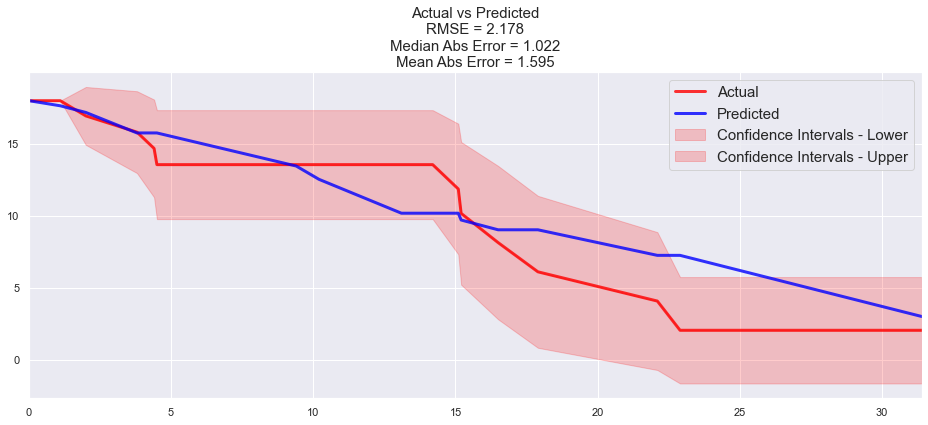

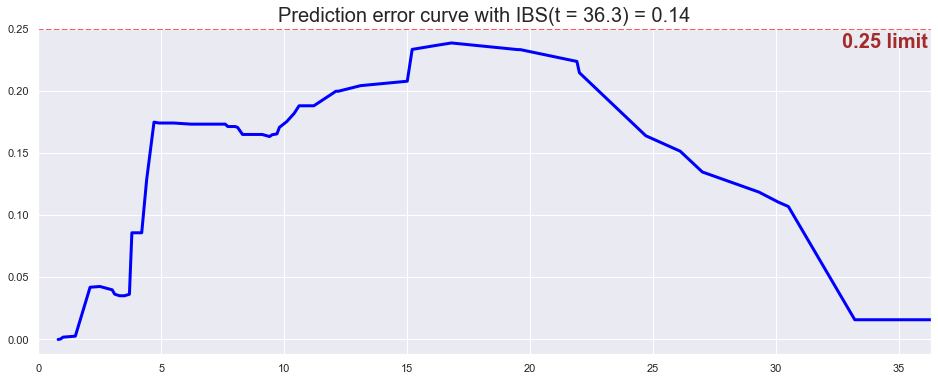

C-index: 0.75
IBS: 0.14

 2 of kfold 5


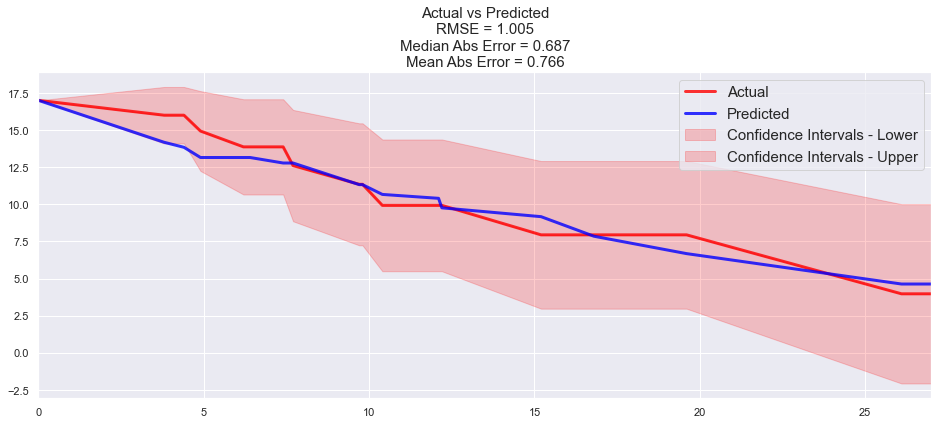

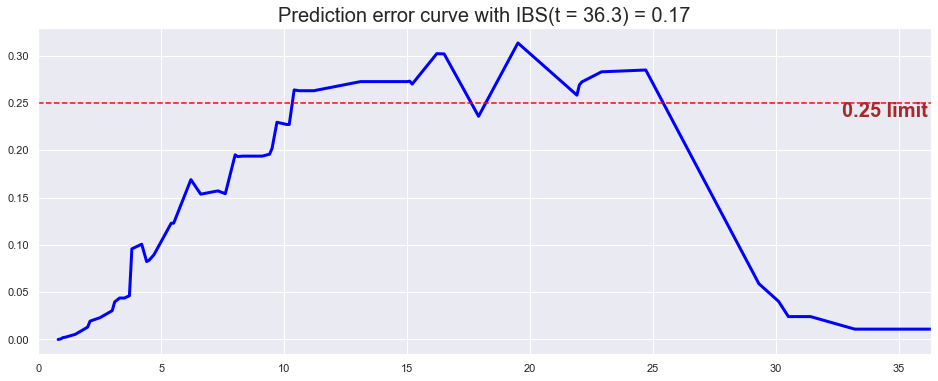

C-index: 0.59
IBS: 0.17

 3 of kfold 5


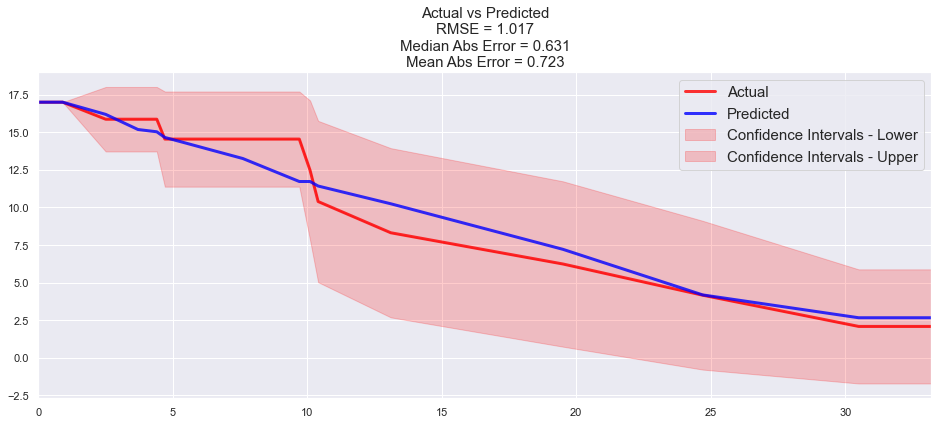

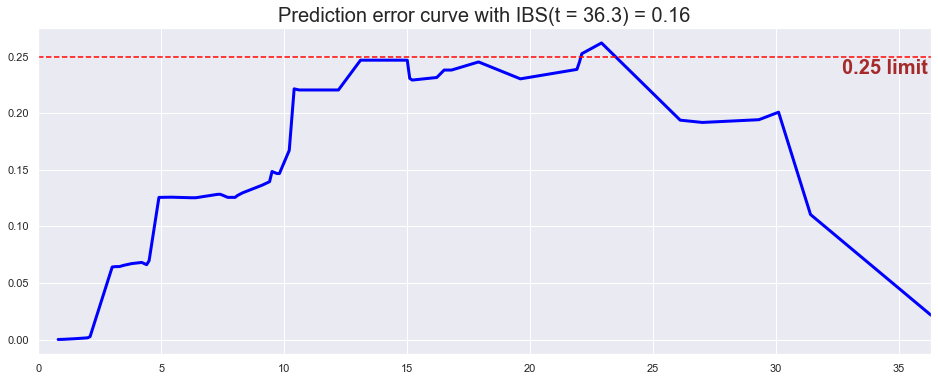

C-index: 0.61
IBS: 0.16

 4 of kfold 5


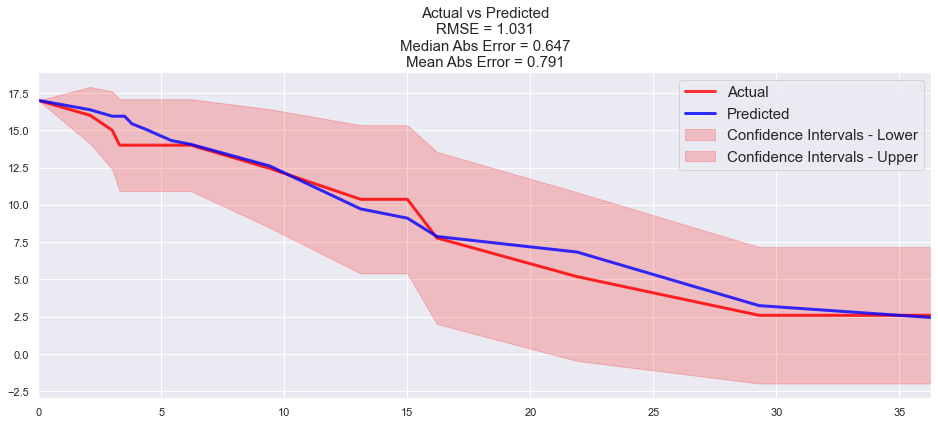

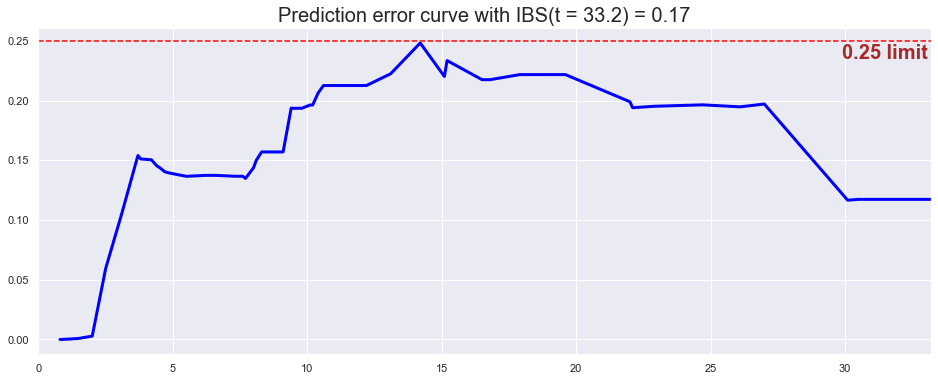

C-index: 0.57
IBS: 0.17

 5 of kfold 5


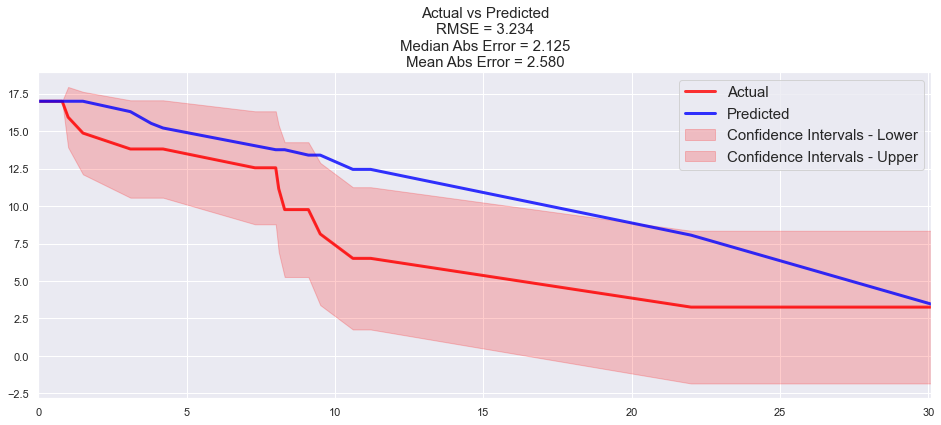

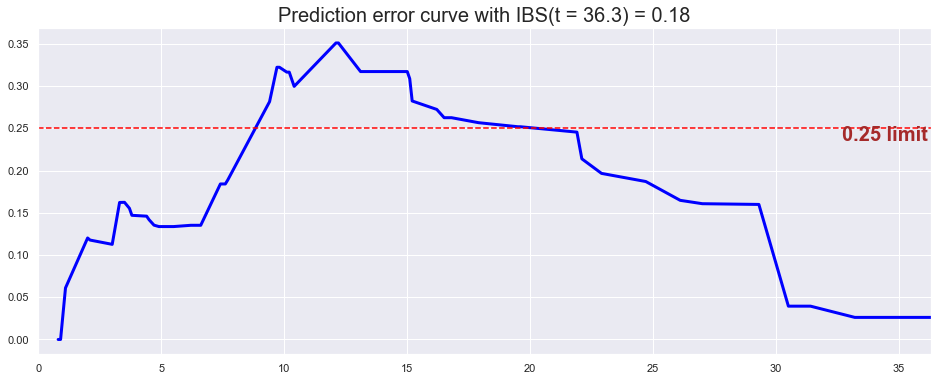

C-index: 0.65
IBS: 0.18

 

Processing: liver_sub_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


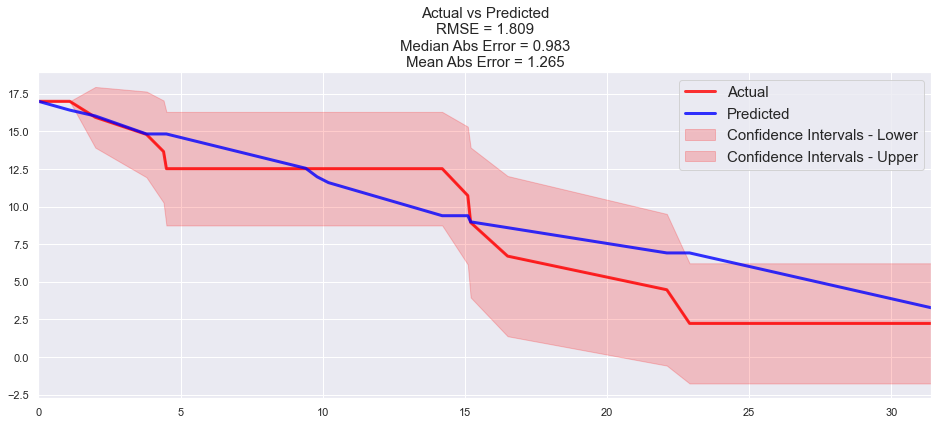

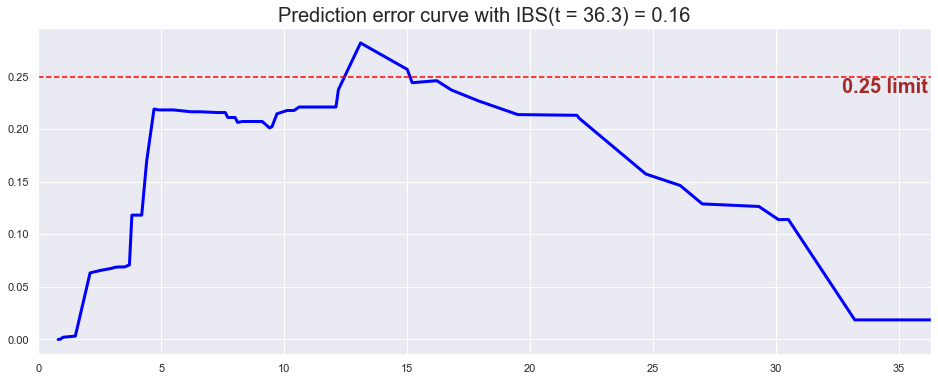

C-index: 0.57
IBS: 0.16

 2 of kfold 5


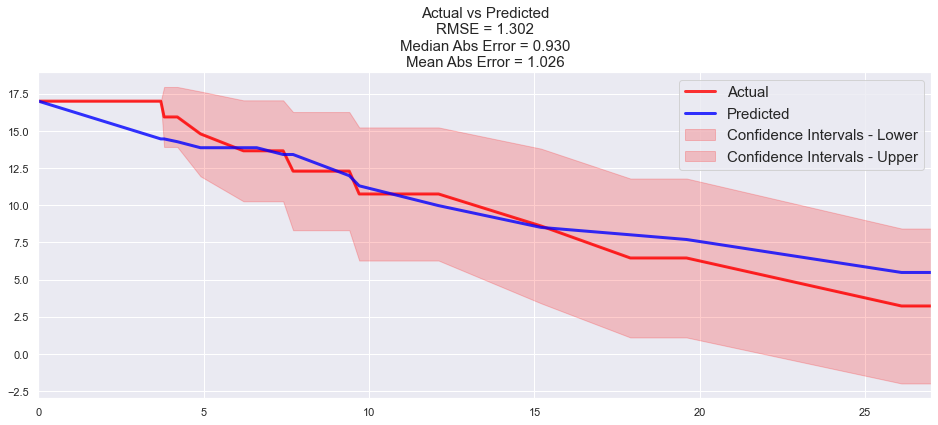

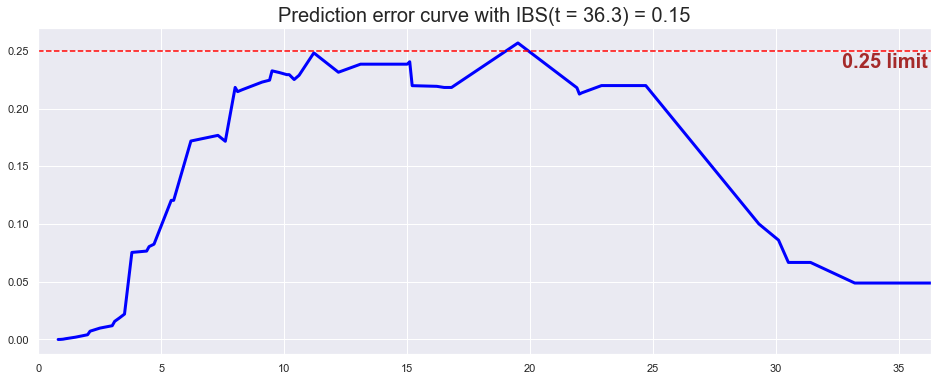

C-index: 0.60
IBS: 0.15

 3 of kfold 5


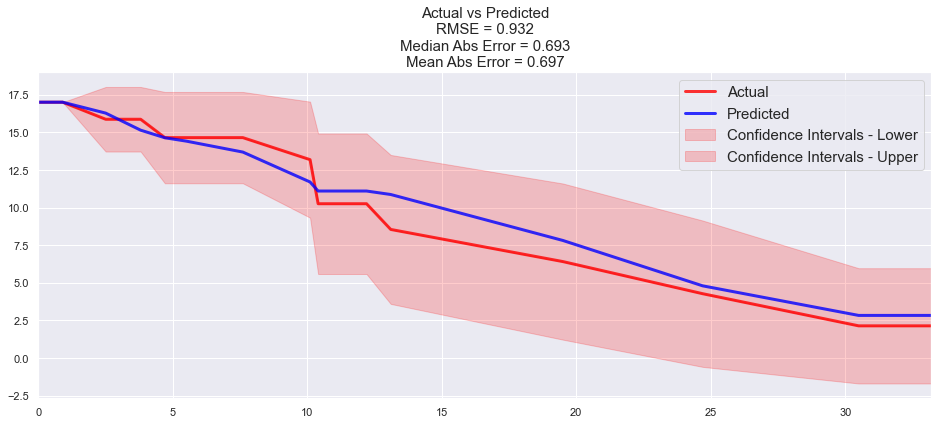

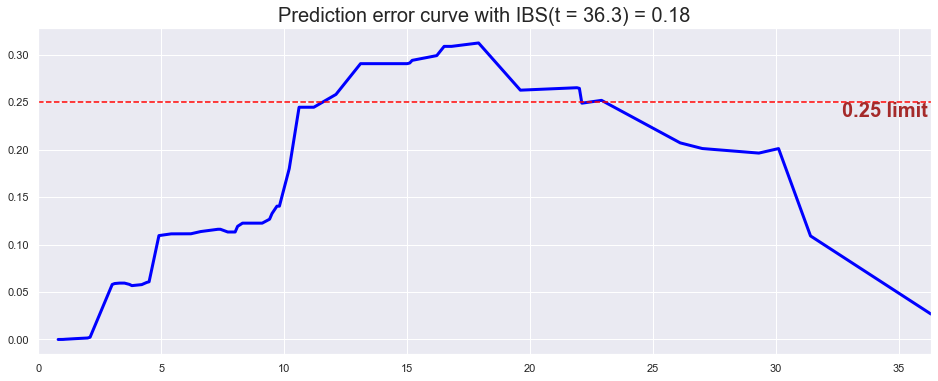

C-index: 0.51
IBS: 0.18

 4 of kfold 5


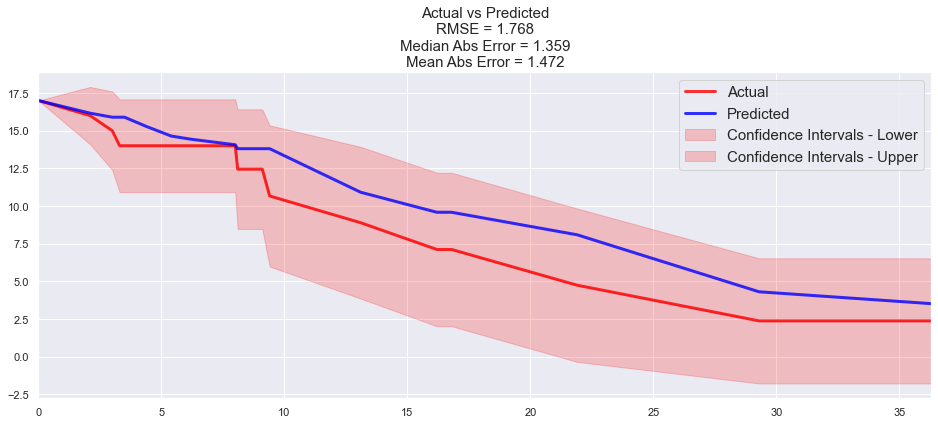

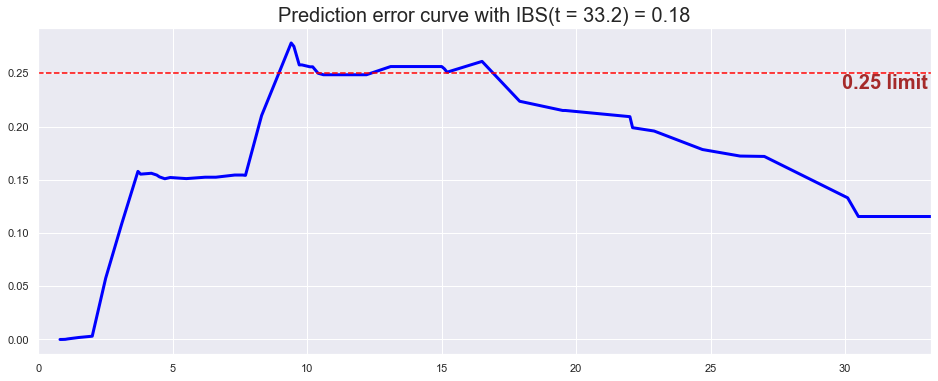

C-index: 0.57
IBS: 0.18

 5 of kfold 5


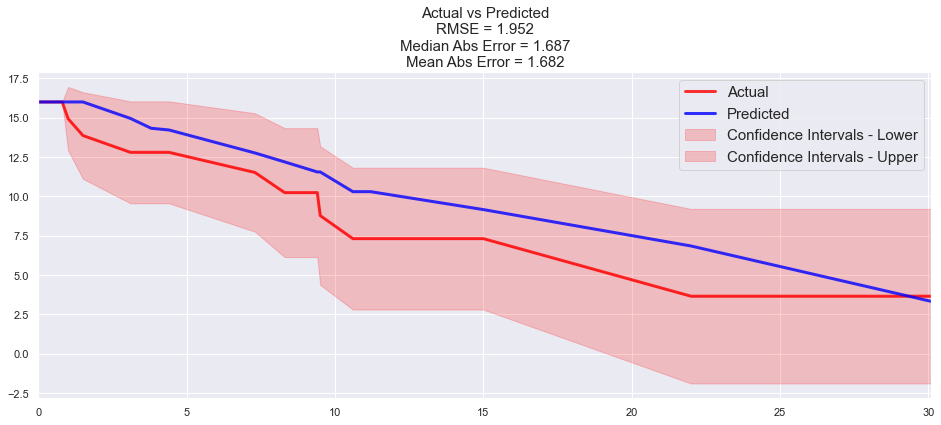

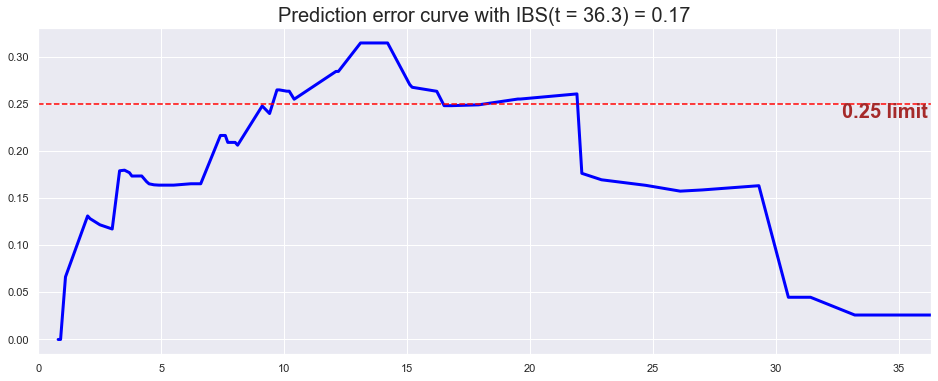

C-index: 0.62
IBS: 0.17

 

Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


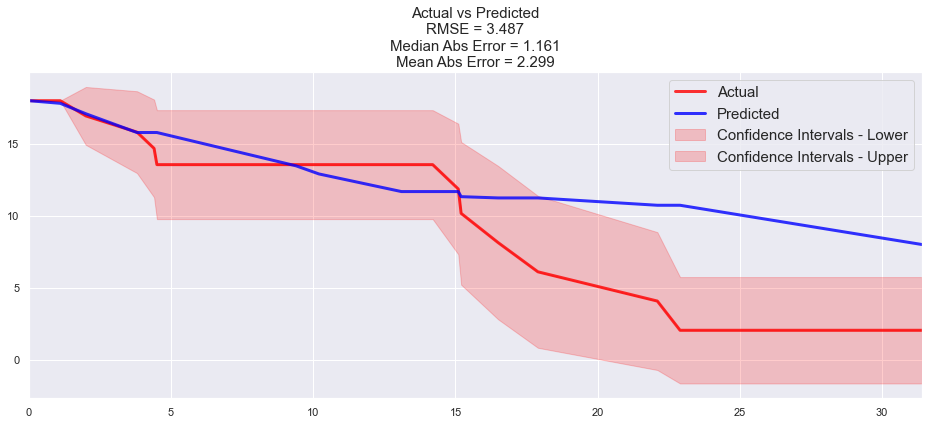

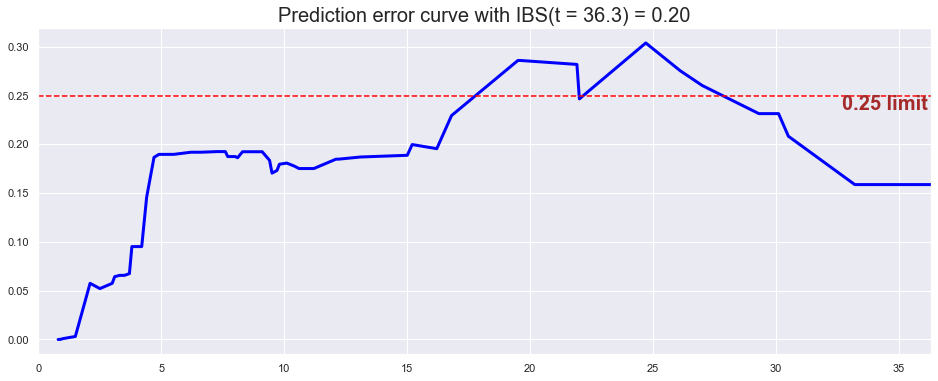

C-index: 0.64
IBS: 0.20

 2 of kfold 5


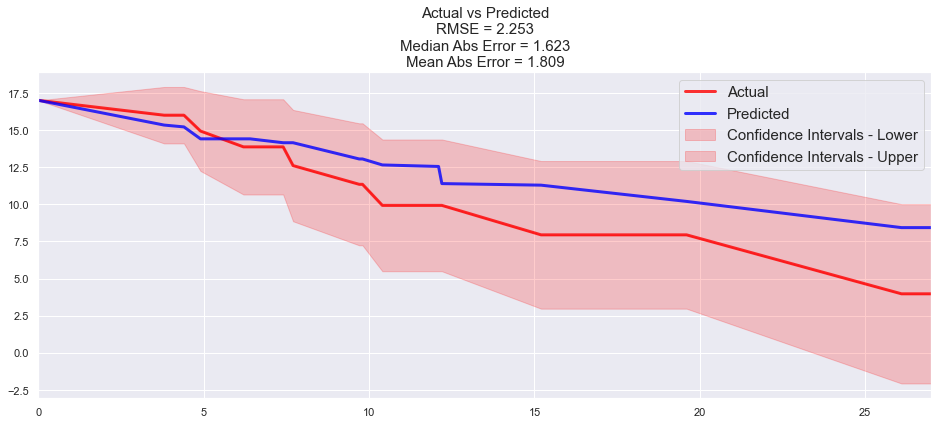

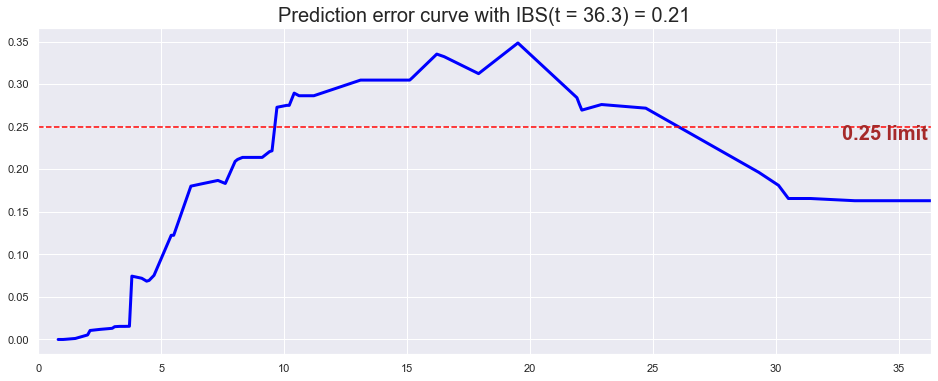

C-index: 0.56
IBS: 0.21

 3 of kfold 5


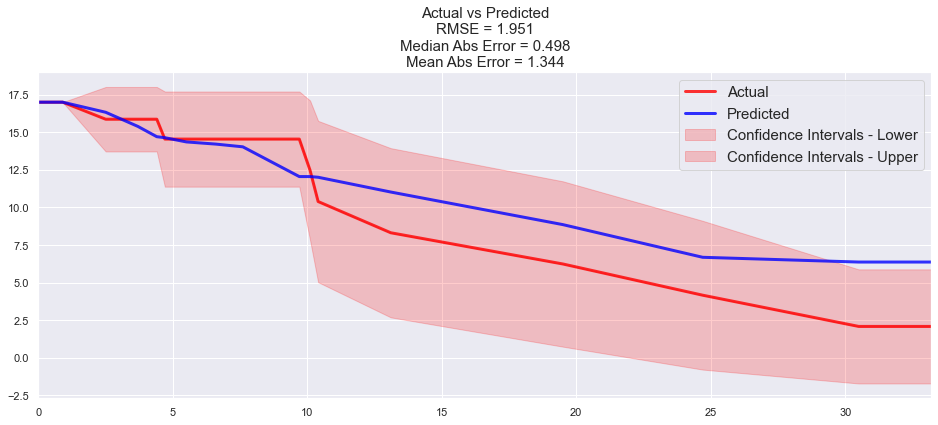

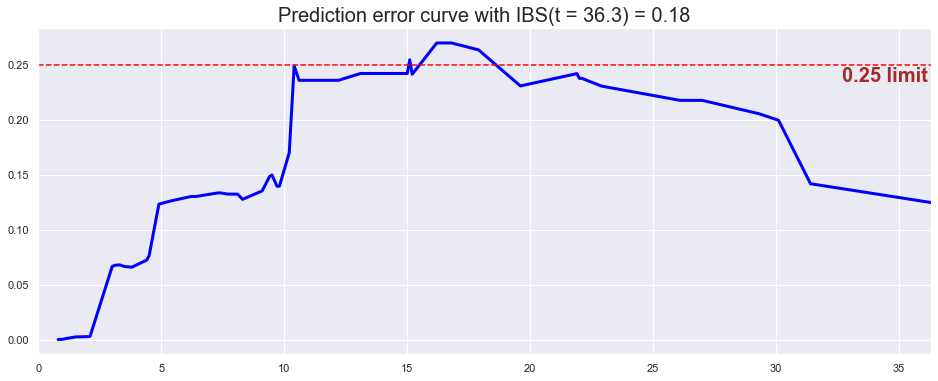

C-index: 0.68
IBS: 0.18

 4 of kfold 5


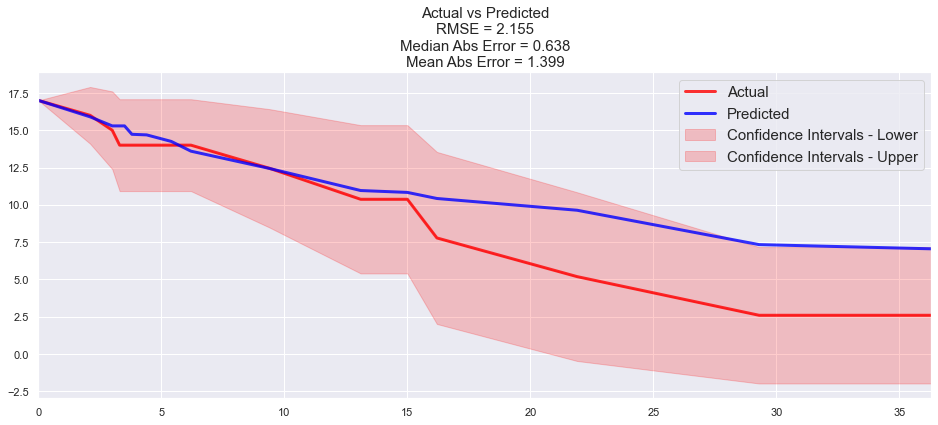

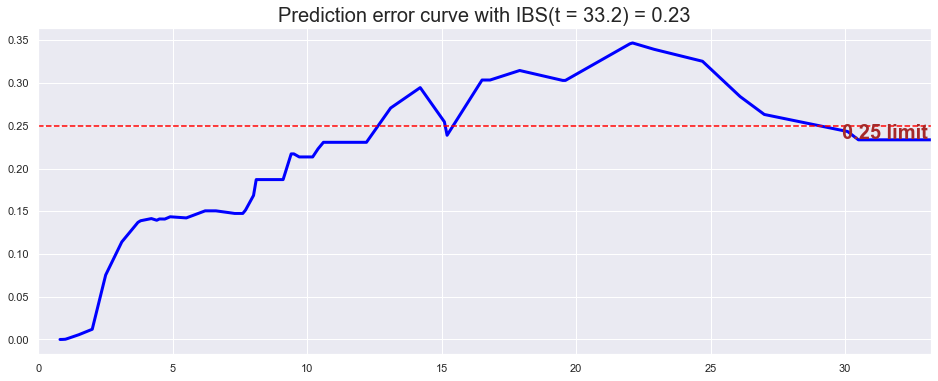

C-index: 0.59
IBS: 0.23

 5 of kfold 5


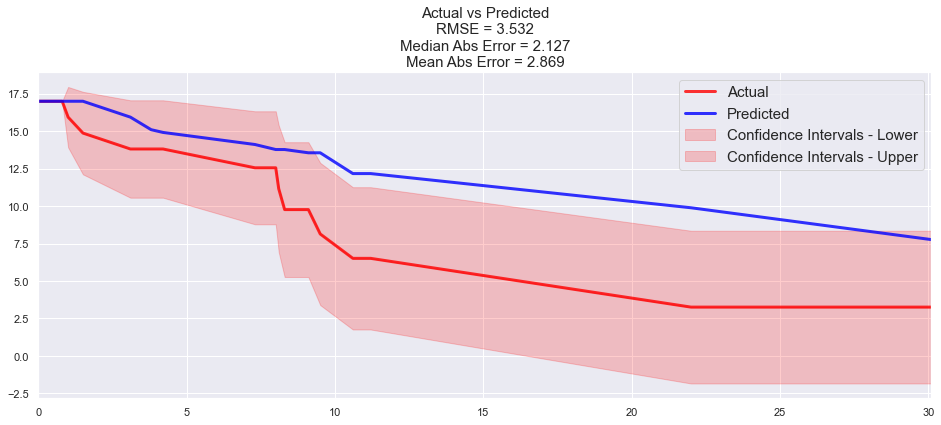

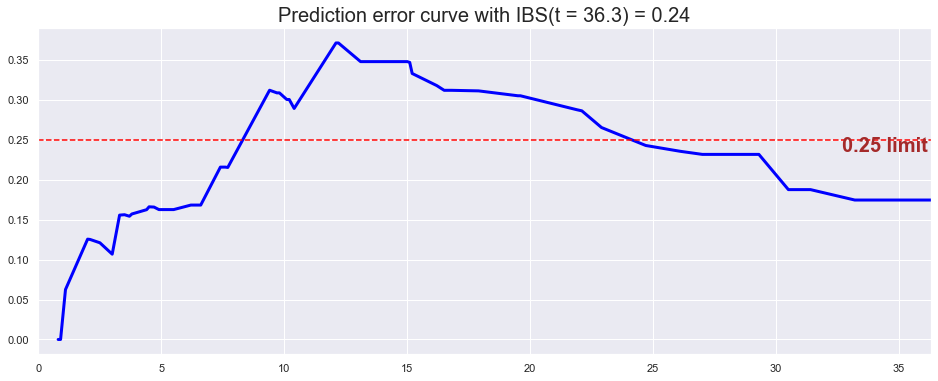

C-index: 0.51
IBS: 0.24

 

Processing: gtv_0.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_0.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


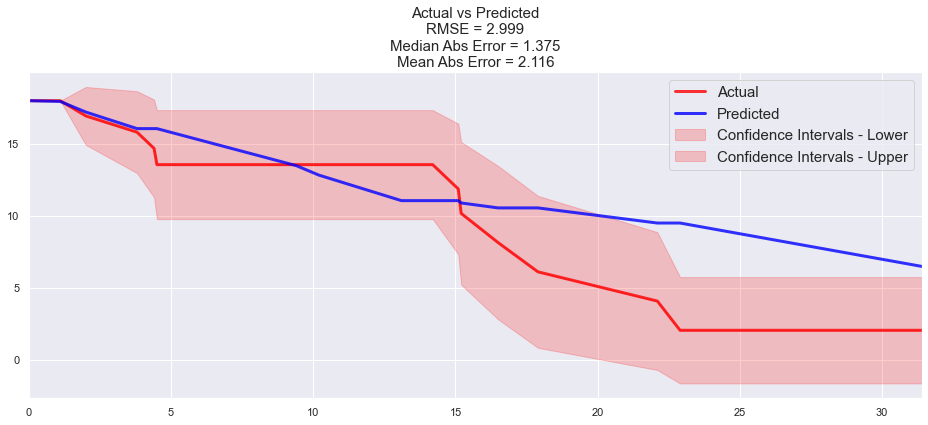

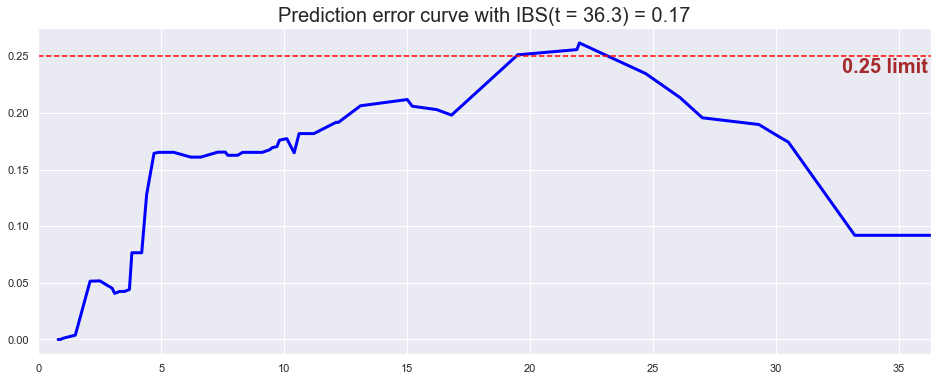

C-index: 0.67
IBS: 0.17

 2 of kfold 5


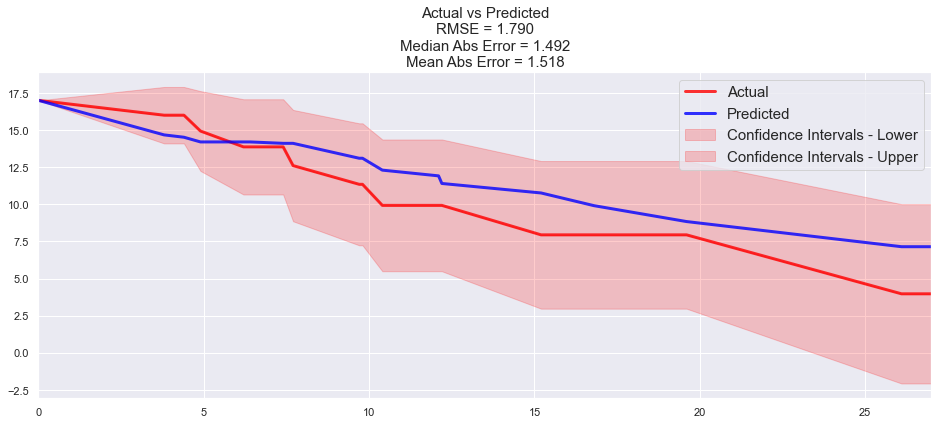

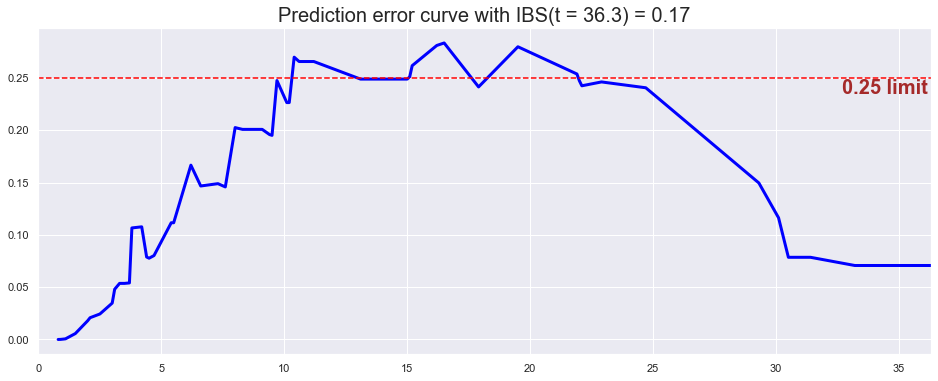

C-index: 0.60
IBS: 0.17

 3 of kfold 5


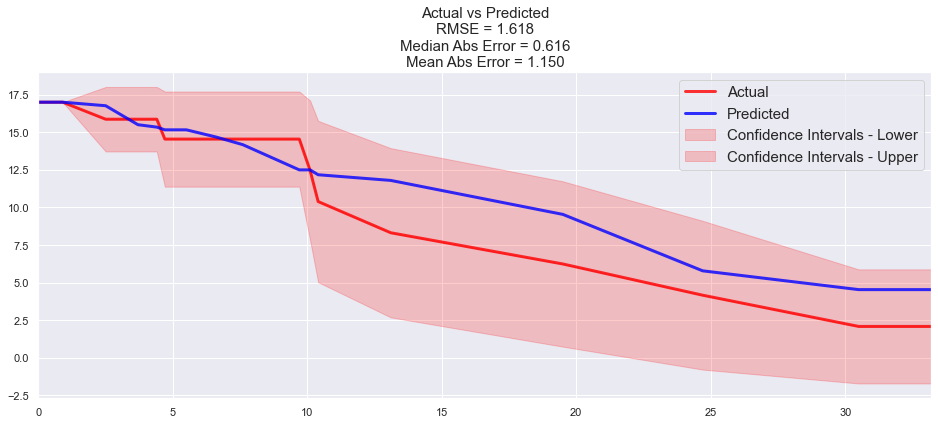

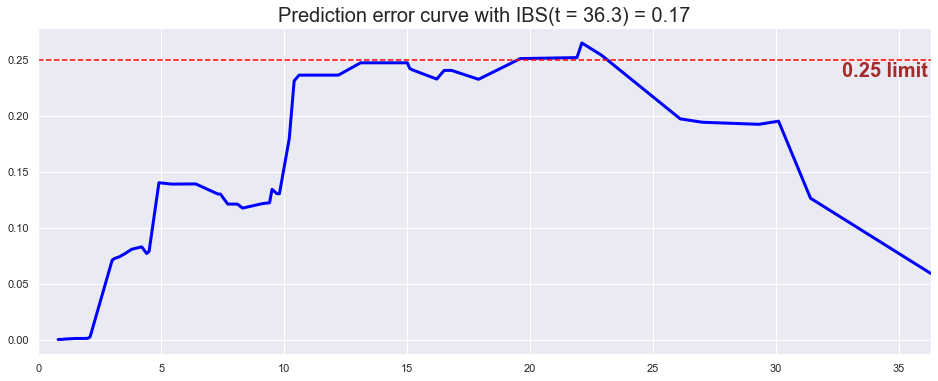

C-index: 0.67
IBS: 0.17

 4 of kfold 5


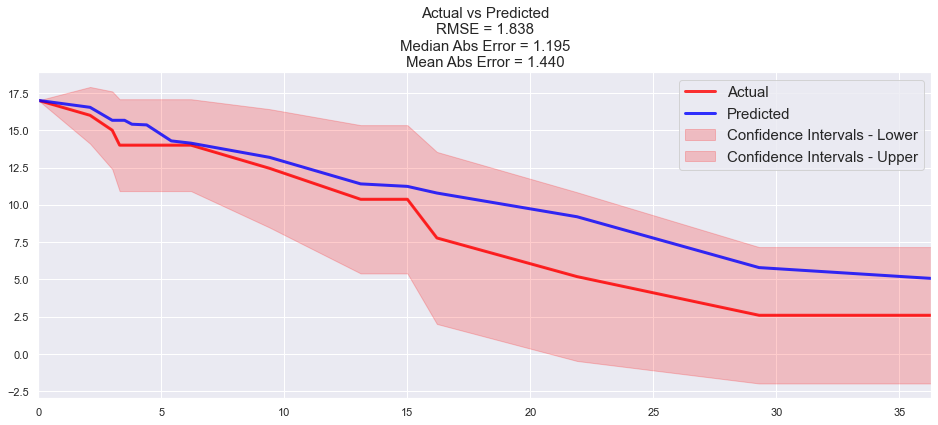

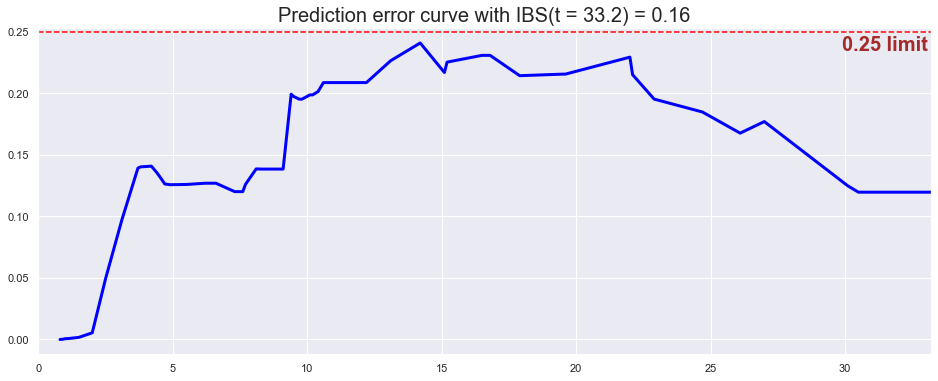

C-index: 0.54
IBS: 0.16

 5 of kfold 5


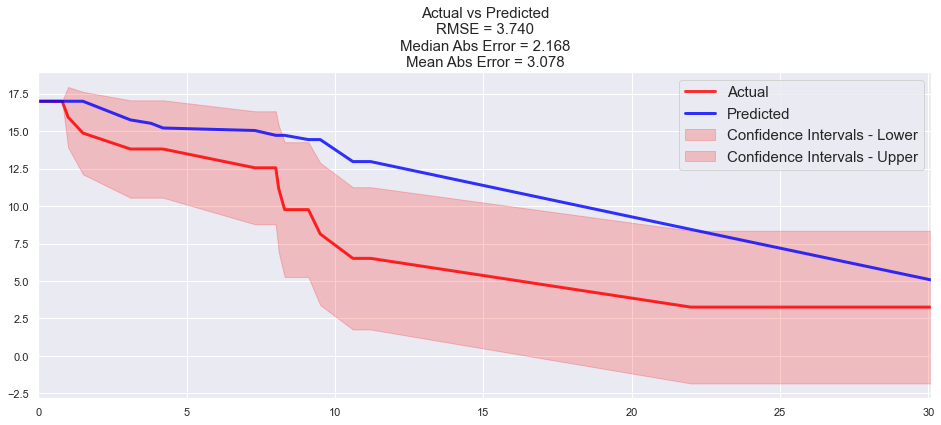

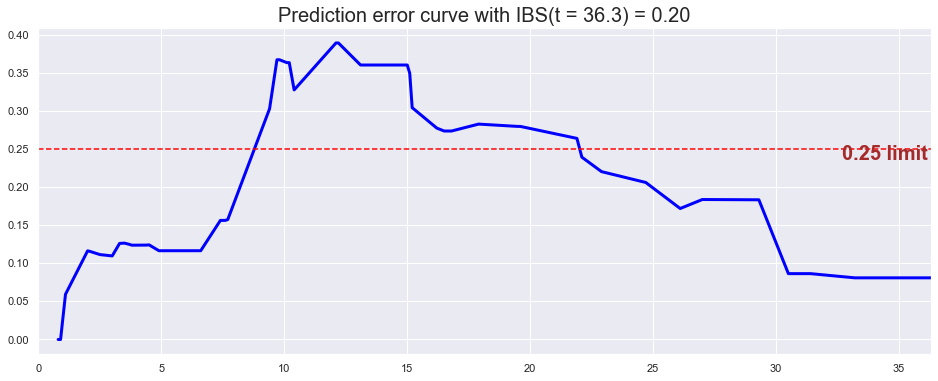

C-index: 0.61
IBS: 0.20

 

Processing: gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


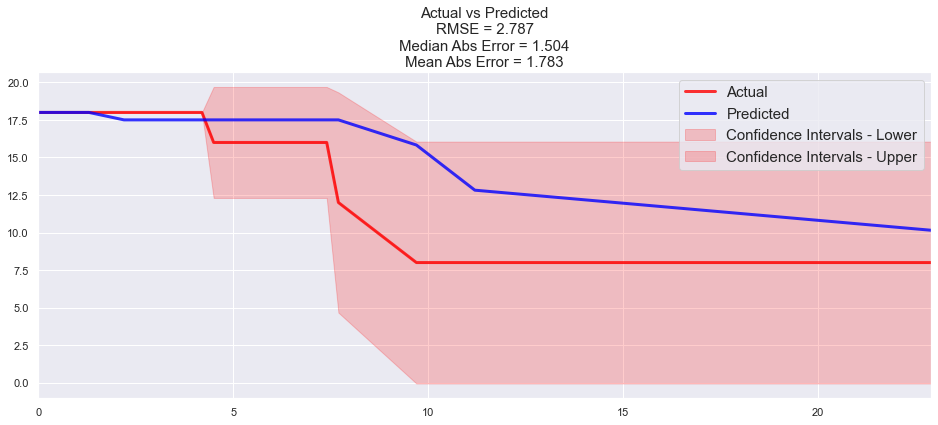

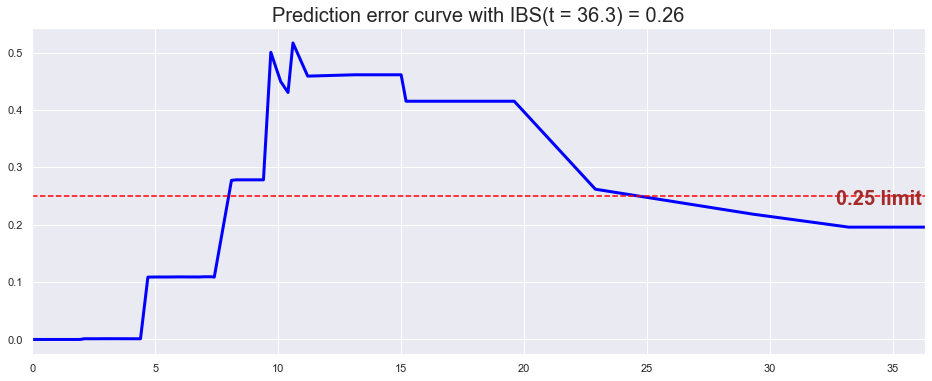

C-index: 0.61
IBS: 0.26

 2 of kfold 5


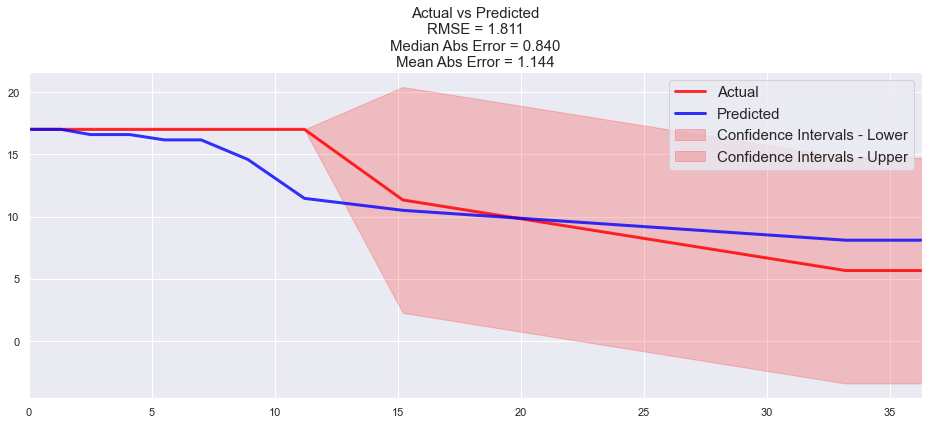

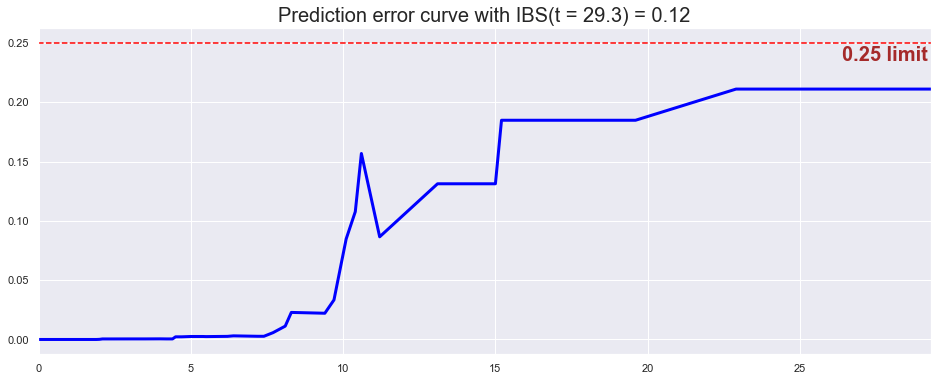

C-index: 0.67
IBS: 0.12

 3 of kfold 5


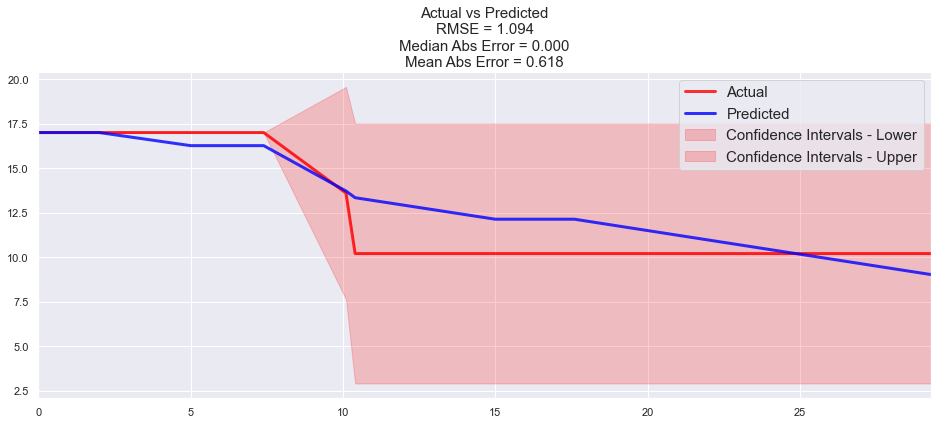

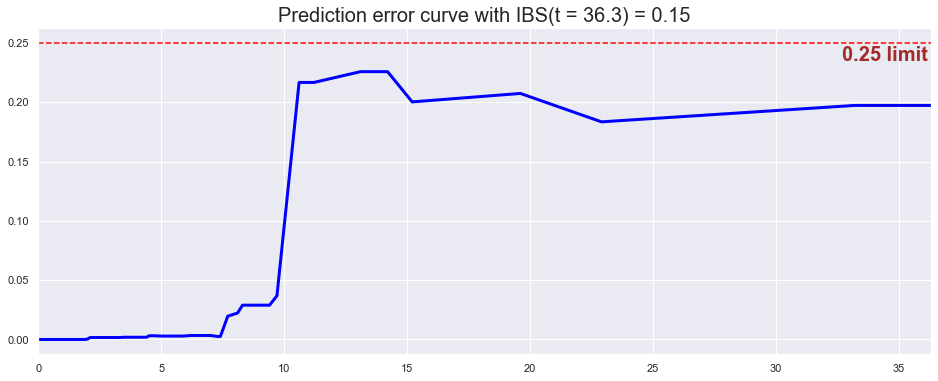

C-index: 0.86
IBS: 0.15

 4 of kfold 5


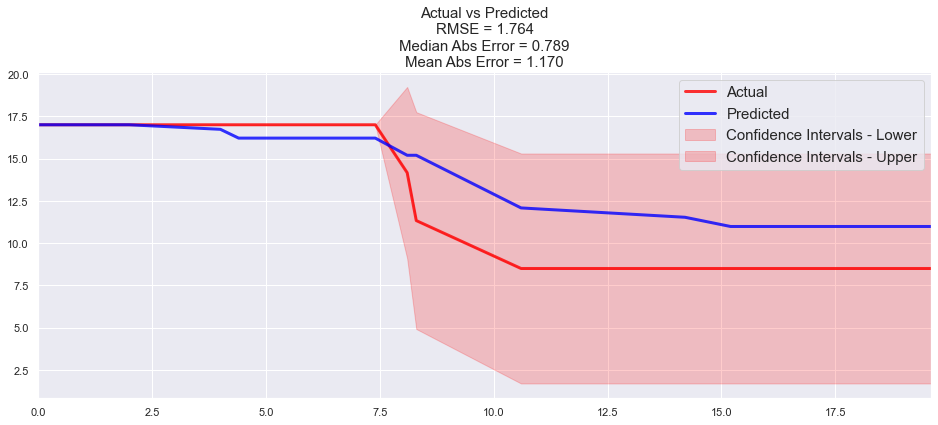

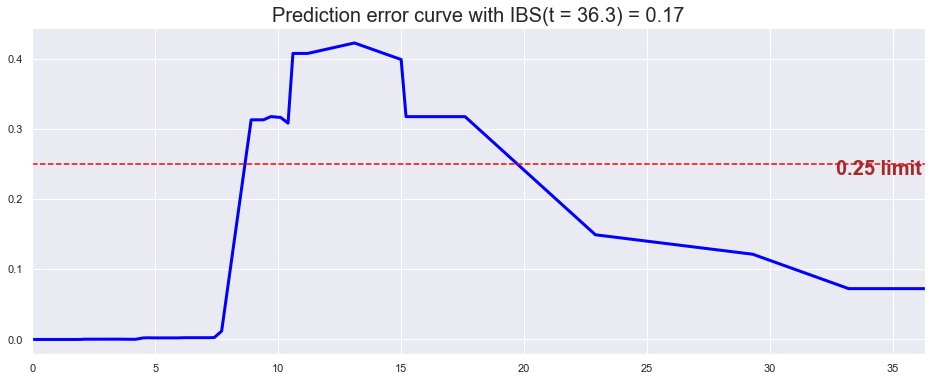

C-index: 0.75
IBS: 0.17

 5 of kfold 5


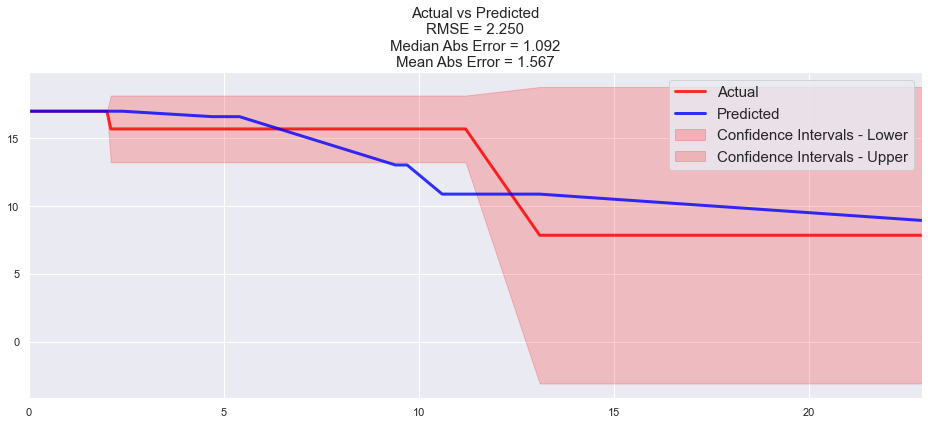

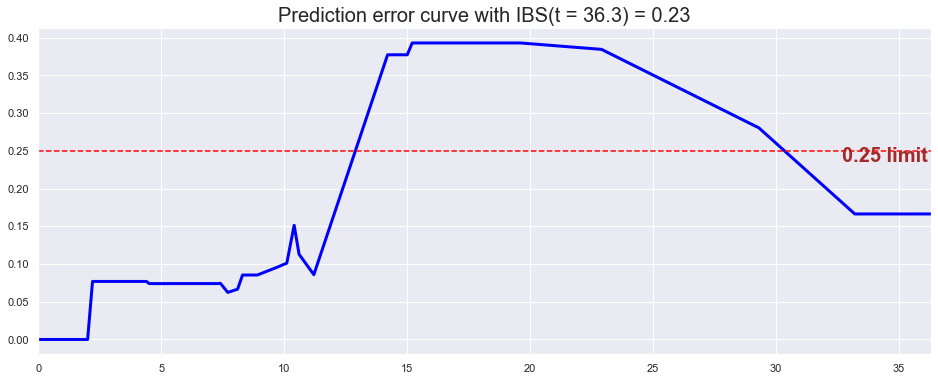

C-index: 0.73
IBS: 0.23

 

Processing: liver_sub_gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


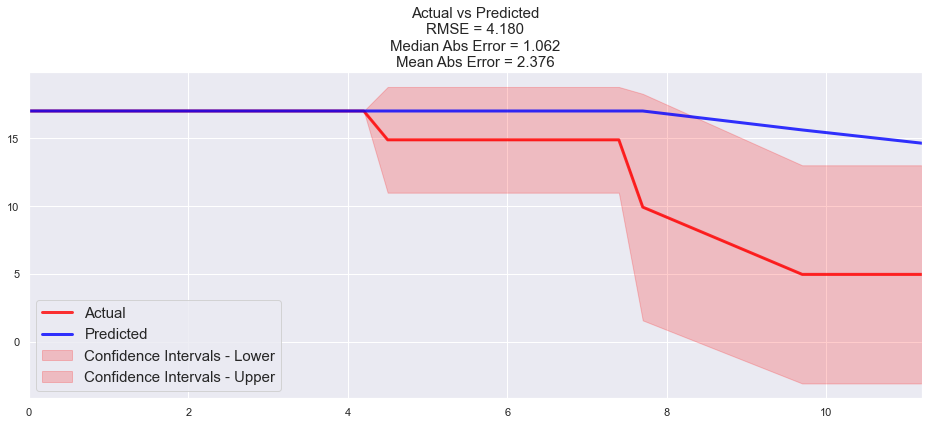

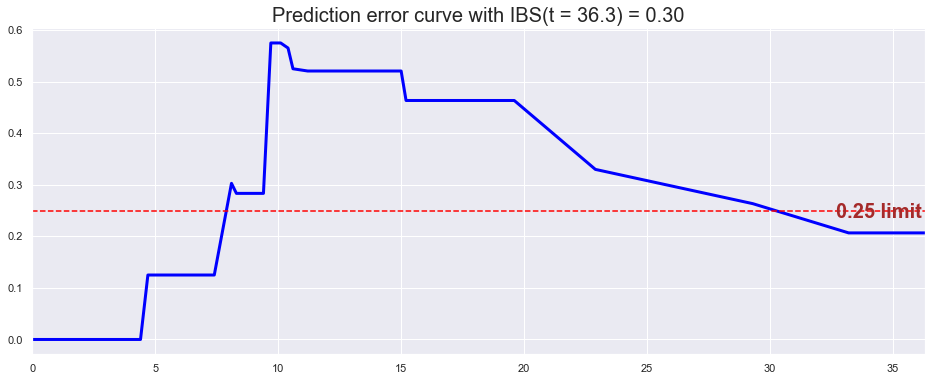

C-index: 0.55
IBS: 0.30

 2 of kfold 5


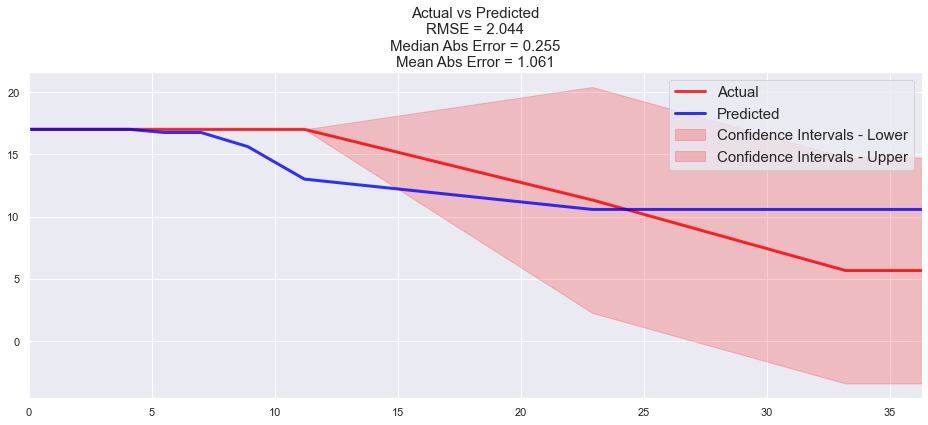

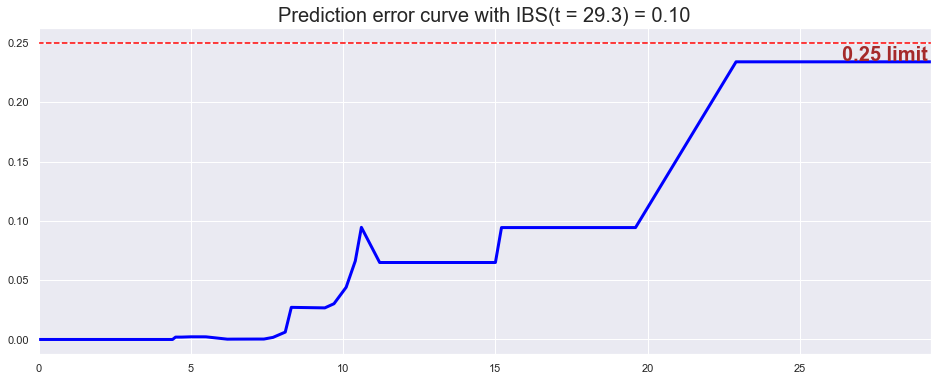

C-index: 0.67
IBS: 0.10

 3 of kfold 5


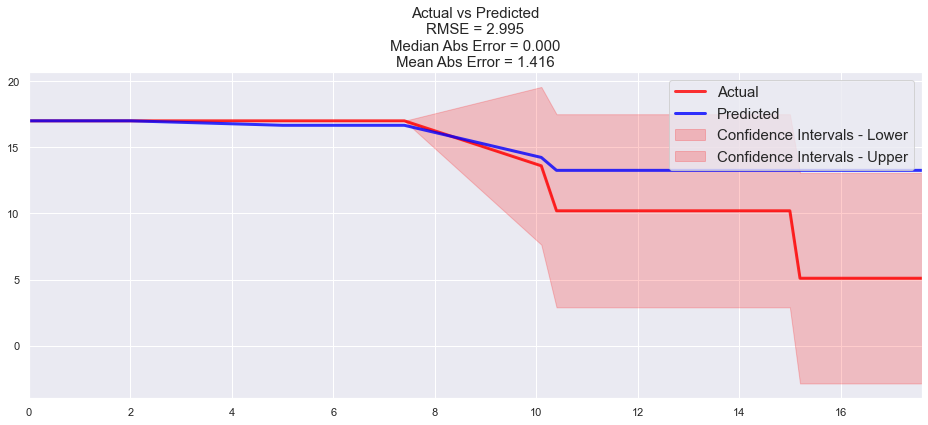

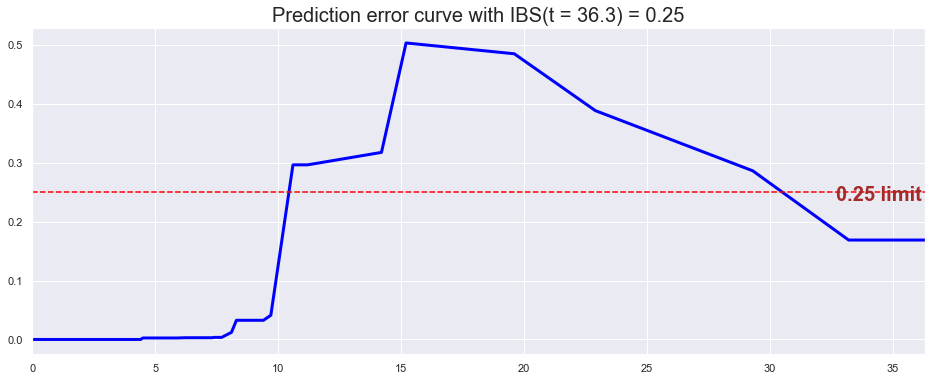

C-index: 0.57
IBS: 0.25

 4 of kfold 5


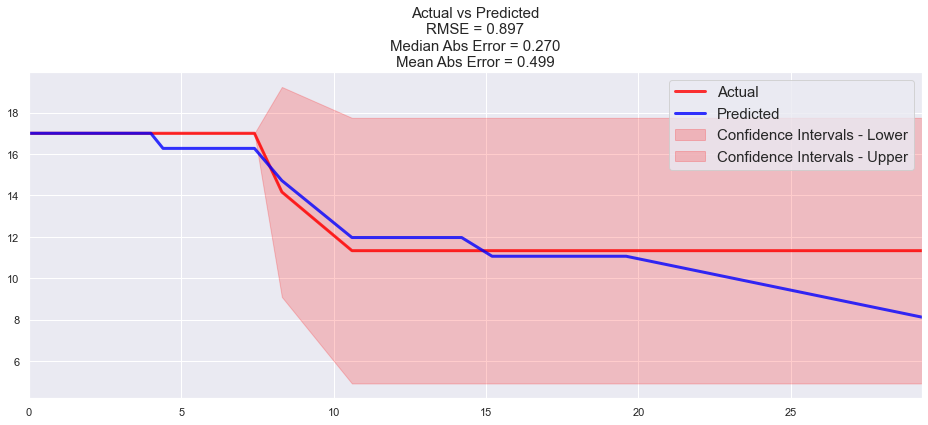

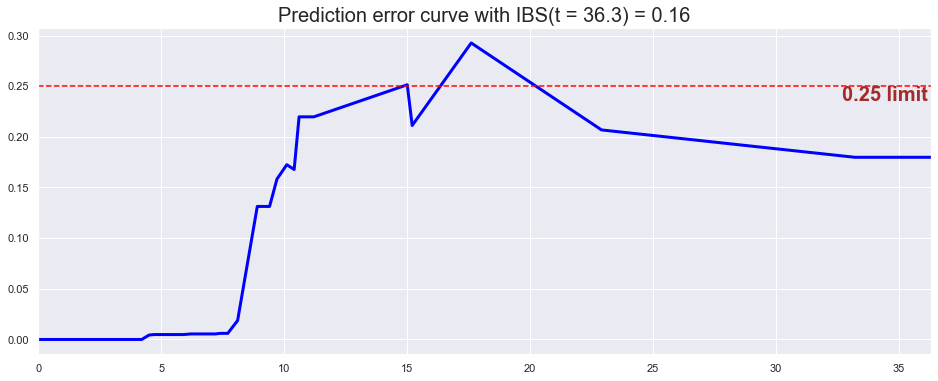

C-index: 0.67
IBS: 0.16

 5 of kfold 5


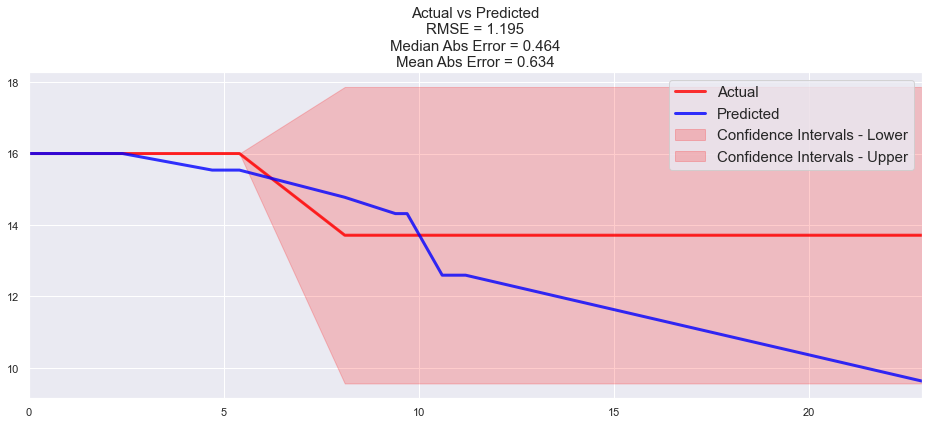

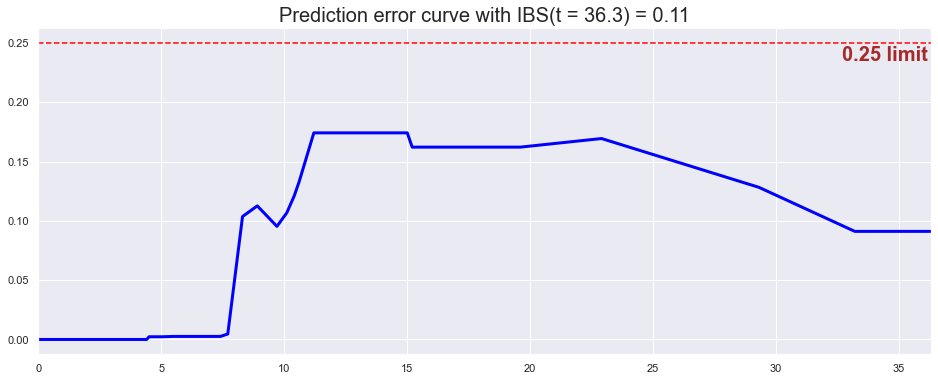

C-index: 0.67
IBS: 0.11

 

Processing: liver_plus_gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


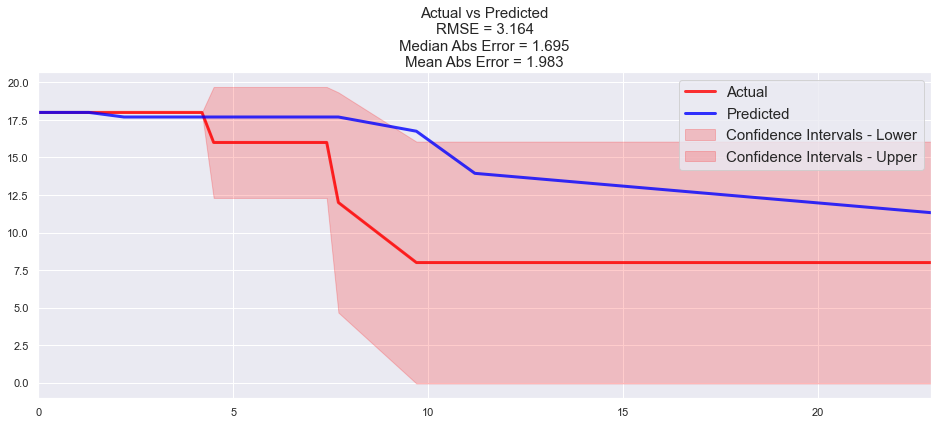

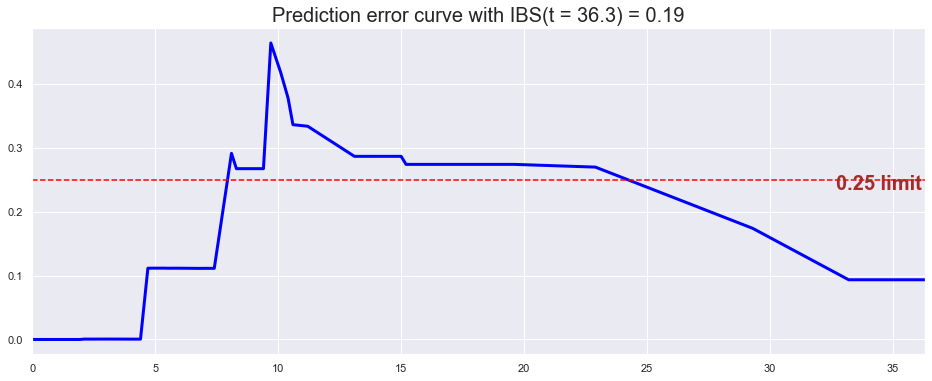

C-index: 0.64
IBS: 0.19

 2 of kfold 5


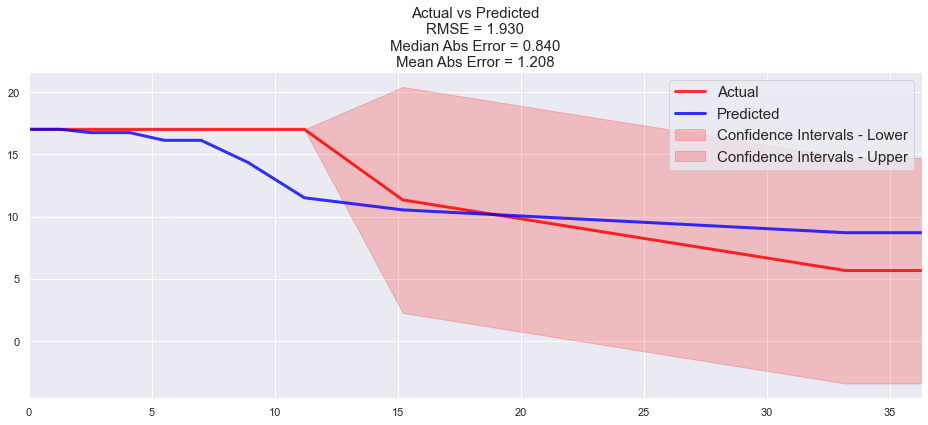

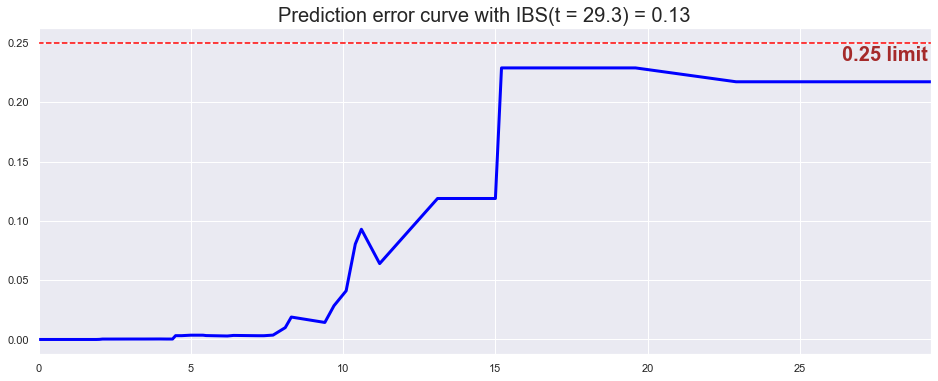

C-index: 0.67
IBS: 0.13

 3 of kfold 5


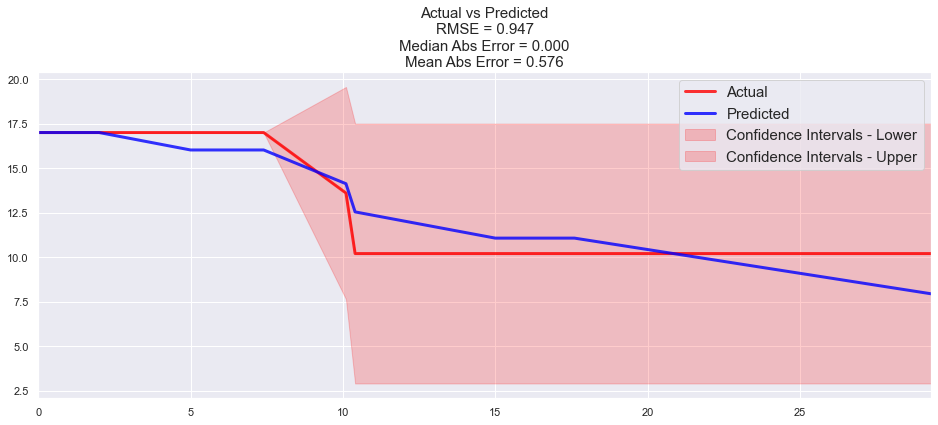

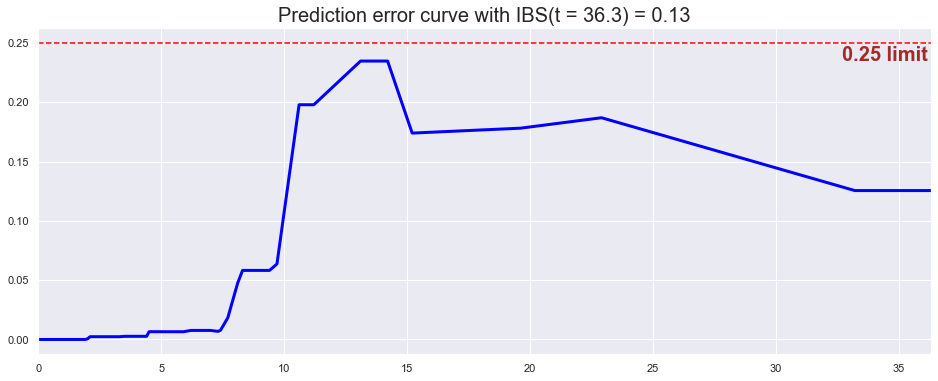

C-index: 0.86
IBS: 0.13

 4 of kfold 5


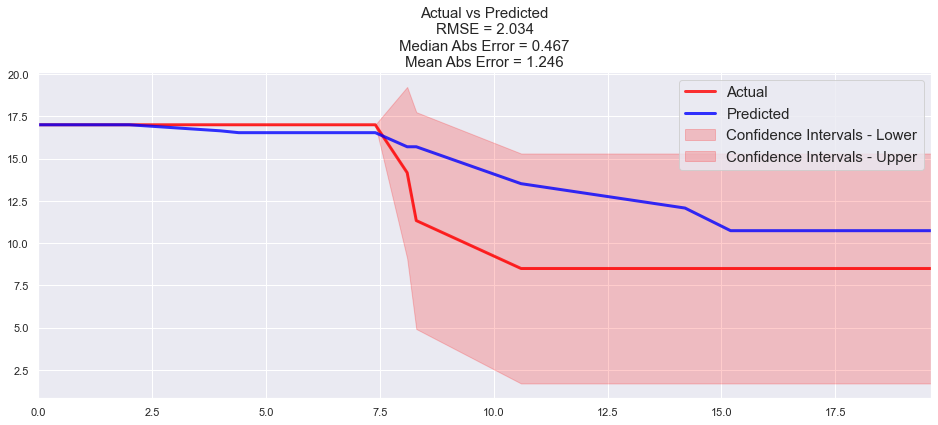

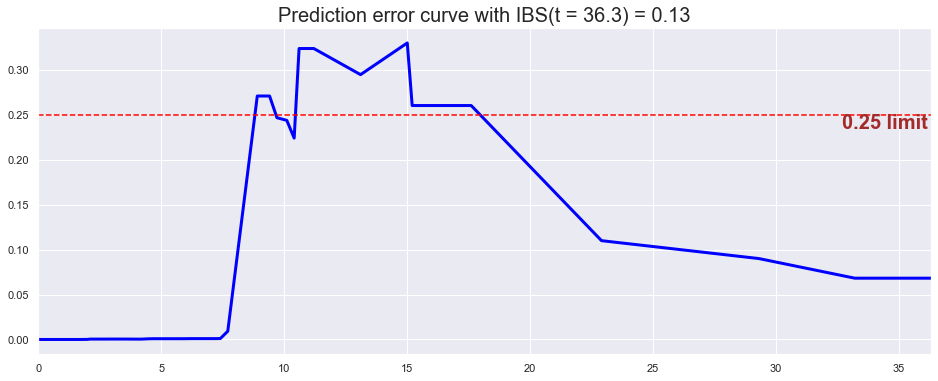

C-index: 0.67
IBS: 0.13

 5 of kfold 5


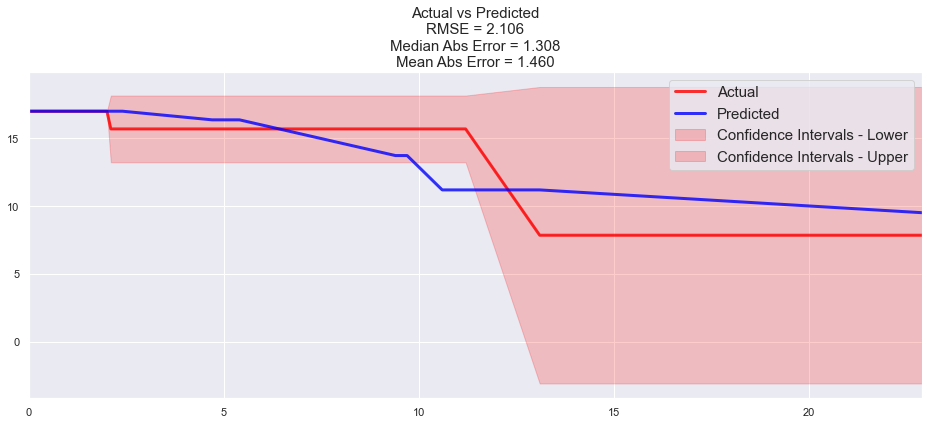

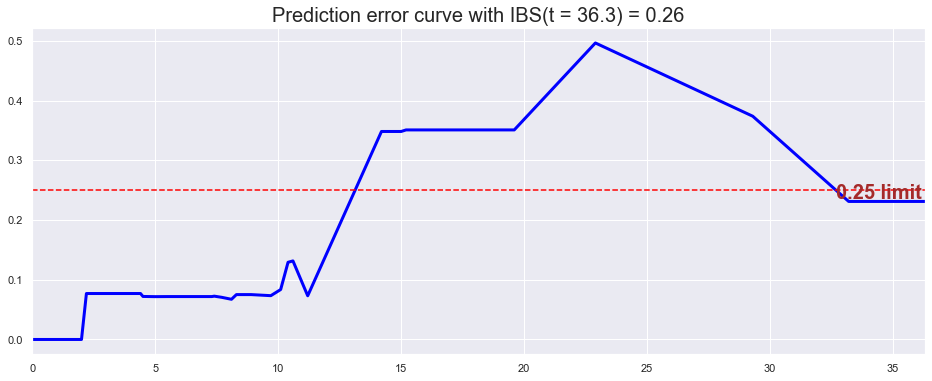

C-index: 0.73
IBS: 0.26

 

Processing: gtv_0_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_0_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


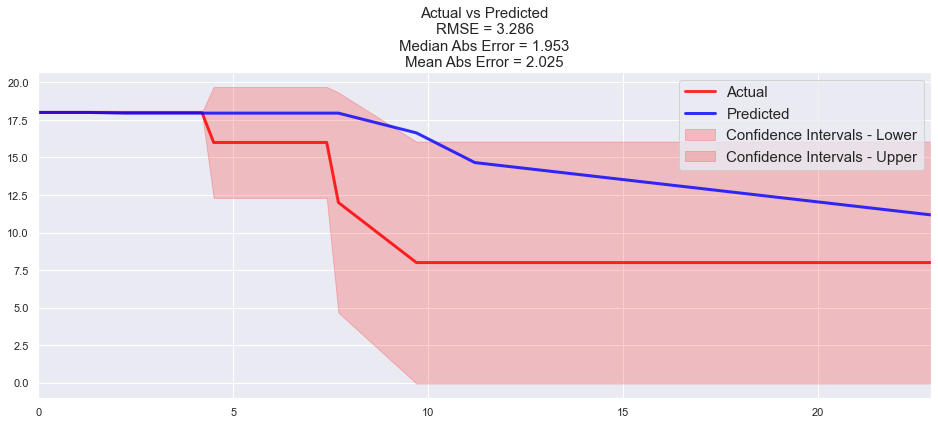

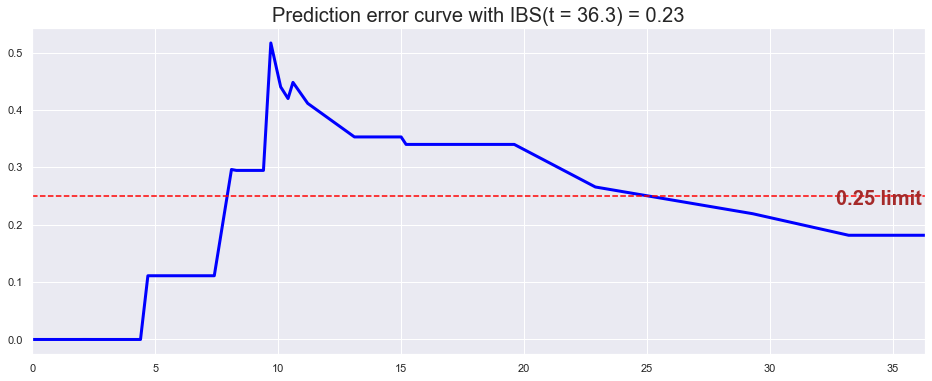

C-index: 0.57
IBS: 0.23

 2 of kfold 5


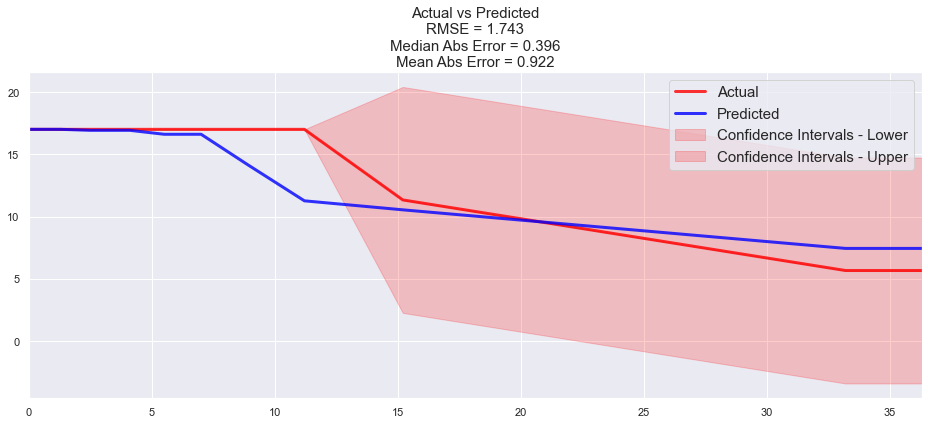

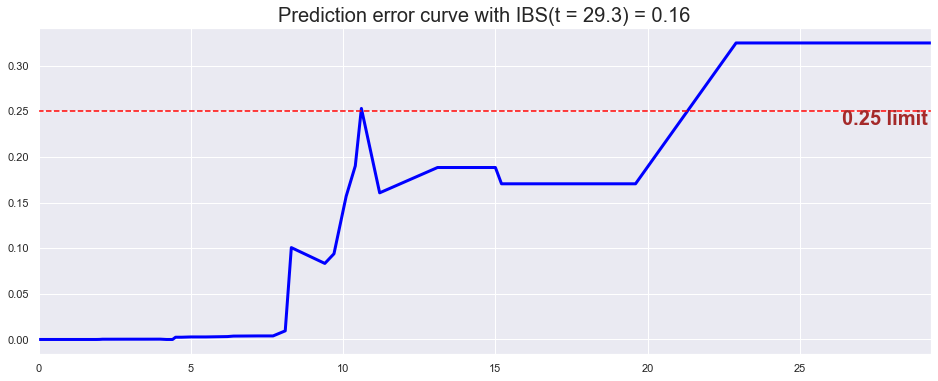

C-index: 1.00
IBS: 0.16

 3 of kfold 5


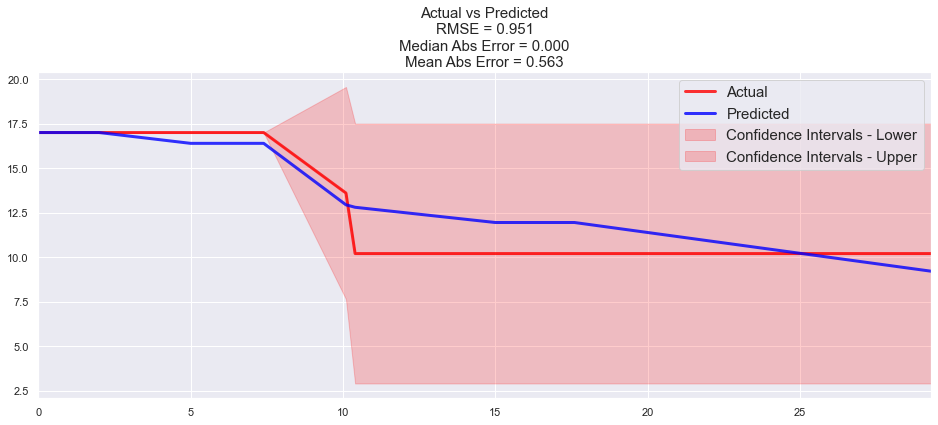

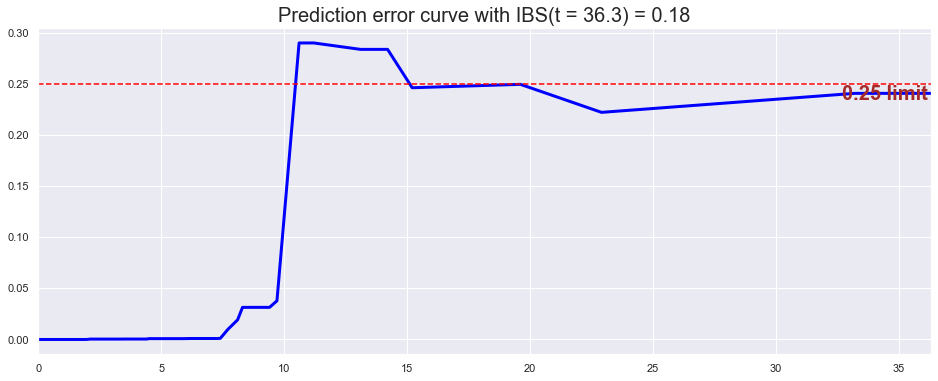

C-index: 0.57
IBS: 0.18

 4 of kfold 5


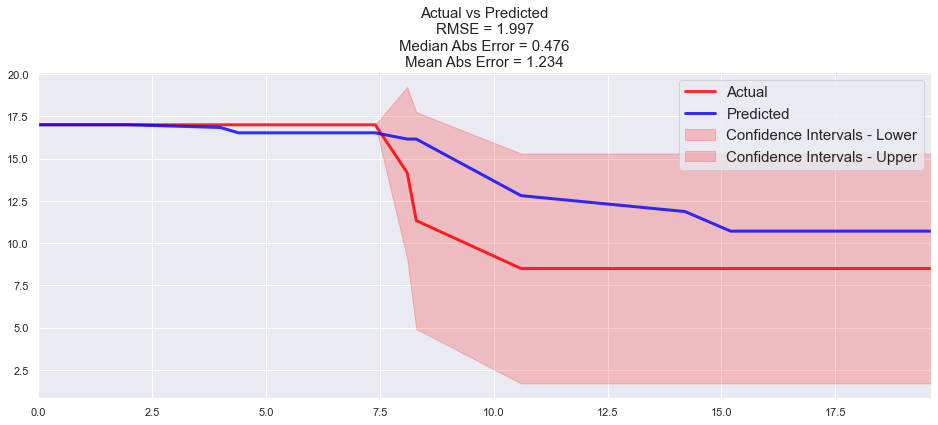

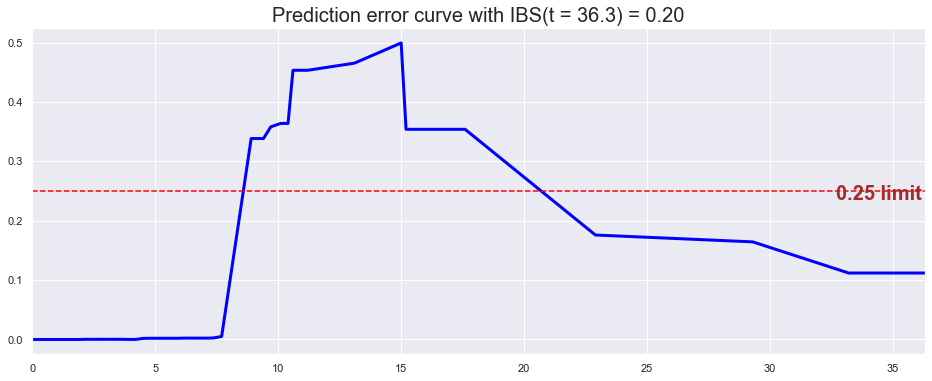

C-index: 0.75
IBS: 0.20

 5 of kfold 5


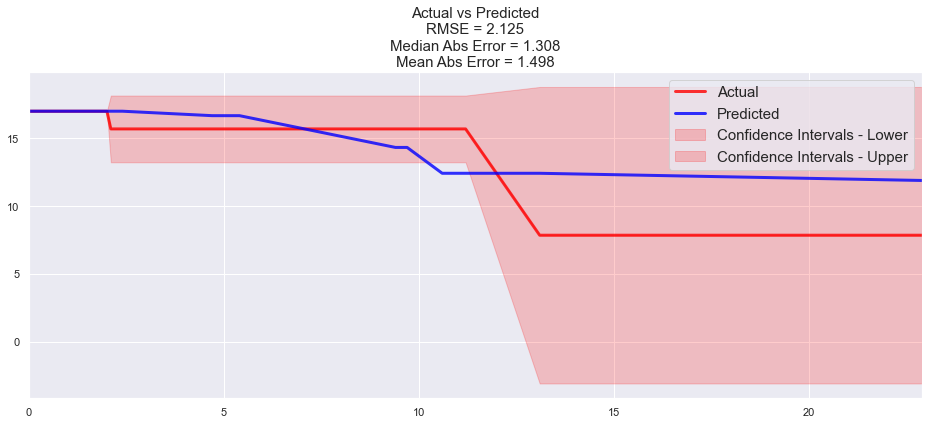

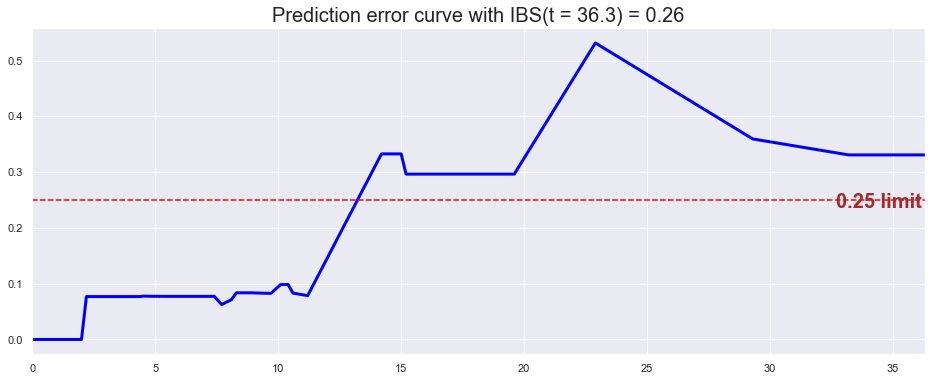

C-index: 0.98
IBS: 0.26

 

Processing: clin_variables_fflp.csv

Feature Selecting... 

Computing feature selection...



KeyError: "['Unnamed: 0'] not found in axis"

In [33]:
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

In [12]:
results_DF

Data  Best Gridsearch CI    CI Avg    CI STD  \
0                            gtv.csv            0.765267  0.612734  0.086867   
1                  liver_sub_gtv.csv            0.673656  0.634586  0.031609   
2                 liver_plus_gtv.csv            0.678103  0.583756  0.054237   
3             gtv_clin_variables.csv            0.740134  0.667673  0.083078   
4   liver_sub_gtv_clin_variables.csv            0.668749  0.575784  0.055725   
5  liver_plus_gtv_clin_variables.csv            0.657524  0.607201  0.076043   
6            clin_variables_only.csv            0.762340  0.720751  0.064459   
7                          gtv_0.csv            0.724885  0.657327  0.095156   
8           gtv_0_clin_variables.csv            0.788548  0.641443  0.146818   

    IBS Avg   IBS STD  Num Trees  Max Depth  Min Node  
0  0.168777  0.021980       10.0        3.0       2.0  
1  0.212864  0.028087       12.0       10.0       2.0  
2  0.165236  0.014456       12.0        2.0      20.0  
3  0.176359  0.031222       15.0       10.0       3.0  
4  0.165153  0.016259       10.0        4.0      15.0  
5  0.166073  0.013237       10.0       15.0      20.0  
6  0.150193  0.010646       12.0        1.0       1.0  
7  0.191964  0.031280       20.0       10.0       2.0  
8  0.179289  0.031172       12.0       15.0       4.0